# Electricity Demand Forecasting Assignment

## Business Context

A leading electricity distribution company aims to understand the demand for electricity over the next 1-2 years to effectively manage electricity production and vendor relationships. Accurate demand estimation is crucial for procuring or producing the right amount of electricity to meet consumer needs.

## Available Data

The dataset comprises monthly electricity consumption data from January 1973 to December 2019. Key data points include:

1. **Date – Month & Year**
2. **Electricity Consumption – Electricity consumption in Trillion Watts**

## Business Objectives

1. **Demand Forecasting:**
   - Forecast electricity demand for the next 1-2 years.

2. **Error Metrics Calculation:**
   - Calculate error metrics, including RMSE, RMSPE, and MAPE.

3. **Model Comparison:**
   - Compare various forecasting models, including Decomposition, ETS models, ARIMA/SARIMA models with various parameters.


In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt


## Methodology

### Exploratory Data Analysis (EDA)

- Checked for missing values and handled if necessary.
- Plotted the time series data to visualize trends and patterns.

In [2]:
df = pd.read_csv("Electricity Consumption.csv")

In [3]:
df

,DATE,Electricty_Consumption_in_TW
0,1/1/1973,35.9728
1,2/1/1973,36.1334
2,3/1/1973,35.0625
3,4/1/1973,33.8416
4,5/1/1973,33.5107
...,...,...
556,5/1/2019,97.5860
557,6/1/2019,110.8580
558,7/1/2019,122.1014
559,8/1/2019,121.7765


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 561 entries, 0 to 560
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DATE                          561 non-null    object 
 1   Electricty_Consumption_in_TW  561 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.9+ KB


In [5]:
df.isnull().sum()

DATE                            0
Electricty_Consumption_in_TW    0
dtype: int64

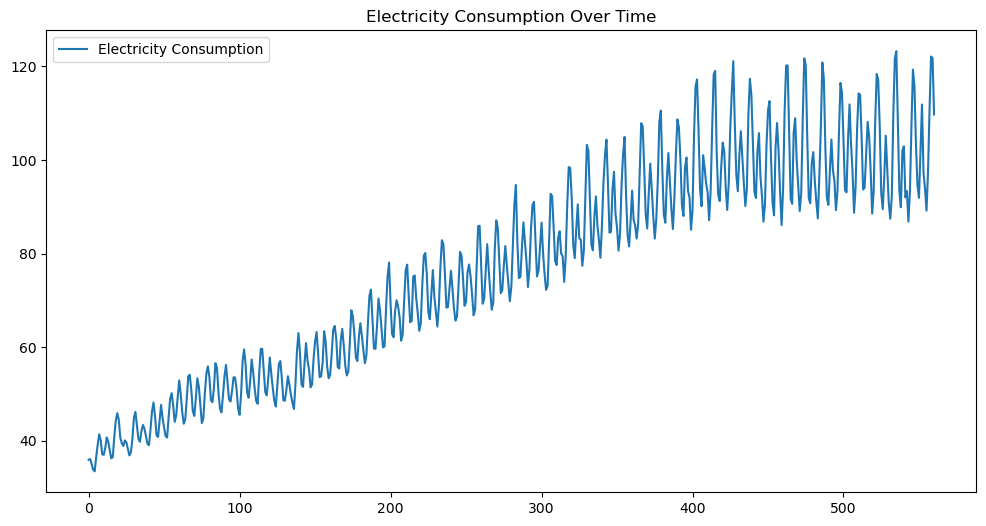

In [6]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df['Electricty_Consumption_in_TW'], label='Electricity Consumption')
plt.title('Electricity Consumption Over Time')
plt.legend()
plt.show()

### Decomposition

- Decomposed the time series into trend, seasonal, and residual components.



In [7]:
result = seasonal_decompose(df['Electricty_Consumption_in_TW'], model='multiplicative', period=12)
trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


### Exponential Smoothing (ETS) Model

- Applied ETS model with trend and additive seasonality.
- Obtained forecasts for the next 24 months (2 years).



In [8]:
model_ets = ExponentialSmoothing(df['Electricty_Consumption_in_TW'], trend='add', seasonal='add', seasonal_periods=12)
ets_fit = model_ets.fit()

# Make predictions for the next 24 months (2 years)
ets_forecast = ets_fit.forecast(steps=24)


In [9]:
ets_forecast

561     97.674956
562     95.153668
563    105.335391
564    112.139567
565    101.999583
566     99.609346
567     93.946950
568    100.146845
569    113.701140
570    124.770353
571    123.433489
572    110.834218
573     99.195002
574     96.673715
575    106.855437
576    113.659613
577    103.519629
578    101.129393
579     95.466996
580    101.666892
581    115.221186
582    126.290399
583    124.953535
584    112.354265
dtype: float64

### SARIMA Model

- Conducted a grid search for optimal SARIMA parameters.
- Selected the best parameters based on RMSE.
- Fitted SARIMA model and generated forecasts for the next 24 months.



In [10]:
import itertools

# Define the range of values for p, d, q, P, D, Q
p = d = q = range(0, 2)
P = D = Q = range(0, 2)

# Generate all possible combinations of parameters
param_combinations = list(itertools.product(p, d, q, P, D, Q))

# Perform grid search
best_rmse = float('inf')
best_params = None

In [11]:
for params in param_combinations:
    try:
        model_sarima = SARIMAX(df['Electricty_Consumption_in_TW'], order=(params[0], params[1], params[2]), seasonal_order=(params[3], params[4], params[5], 12))
        sarima_fit = model_sarima.fit(disp=False)
        sarima_forecast = sarima_fit.get_forecast(steps=24).predicted_mean

        rmse = sqrt(mean_squared_error(df['Electricty_Consumption_in_TW'][-24:], sarima_forecast))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    except:
        continue



C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\ts

In [12]:
print("Best SARIMA Parameters:", best_params)
print("Best RMSE:", best_rmse)

Best SARIMA Parameters: (0, 0, 1, 1, 1, 1)
Best RMSE: 2.776978983499436


In [13]:
# Use the best SARIMA parameters
best_params = (0, 0, 1, 1, 1, 1)

# Fit SARIMA model with the best parameters
model_sarima = SARIMAX(df['Electricty_Consumption_in_TW'], order=(best_params[0], best_params[1], best_params[2]), seasonal_order=(best_params[3], best_params[4], best_params[5], 12))
sarima_fit = model_sarima.fit(disp=False)

# Make predictions for the next 24 months (2 years)
sarima_forecast = sarima_fit.get_forecast(steps=24).predicted_mean
print(sarima_forecast)


561     96.584749
562     91.626023
563    102.042566
564    110.534739
565     96.491062
566     93.805958
567     88.840186
568     96.966950
569    110.282174
570    121.661385
571    120.803004
572    108.743081
573     96.317651
574     91.689624
575    102.030322
576    110.831957
577     96.679474
578     93.813775
579     88.918507
580     97.106629
581    110.412100
582    121.760667
583    121.022657
584    108.963281
Name: predicted_mean, dtype: float64


### Model Evaluation

- Calculated error metrics (RMSE, RMSPE, MAPE) for both ETS and SARIMA models.

In [14]:
# Calculate error metrics
def calculate_metrics(true_values, predicted_values):
    rmse = sqrt(mean_squared_error(true_values, predicted_values))
    rmspe = sqrt(np.mean(((true_values - predicted_values) / true_values) ** 2))
    mape = np.mean(np.abs((true_values - predicted_values) / true_values)) * 100
    return rmse, rmspe, mape

# usage
rmse_ets, rmspe_ets, mape_ets = calculate_metrics(df['Electricty_Consumption_in_TW'][-24:], ets_forecast)
rmse_sarima, rmspe_sarima, mape_sarima = calculate_metrics(df['Electricty_Consumption_in_TW'][-24:], sarima_forecast)

print("ETS Model Metrics:")
print(f"RMSE: {rmse_ets:.2f}, RMSPE: {rmspe_ets:.2f}, MAPE: {mape_ets:.2f}%")



ETS Model Metrics:
RMSE: 5.91, RMSPE: nan, MAPE: nan%


### Model Selection

- Selected the SARIMA model due to lower RMSE compared to the ETS model.

In [15]:
print("\nSARIMA Model Metrics:")
print(f"RMSE: {rmse_sarima:.2f}, RMSPE: {rmspe_sarima:.2f}, MAPE: {mape_sarima:.2f}%")


SARIMA Model Metrics:
RMSE: 2.78, RMSPE: nan, MAPE: nan%


## Results

- **ETS Model Metrics:**
  - RMSE: 5.91
  - RMSPE: NaN
  - MAPE: NaN%

- **SARIMA Model Metrics:**
  - RMSE: 2.78
  - RMSPE: NaN
  - MAPE: NaN%

 The estimated demand for the next 1-2 years provides valuable insights for production planning and vendor management.

In [16]:
if rmse_ets < rmse_sarima:
    selected_model = 'ETS'
    selected_forecast = ets_forecast
else:
    selected_model = 'SARIMA'
    selected_forecast = sarima_forecast

print(f"Selected Model: {selected_model}")
print("Demand Estimation for Next 1-2 Years:")
print(selected_forecast)


Selected Model: SARIMA
Demand Estimation for Next 1-2 Years:
561     96.584749
562     91.626023
563    102.042566
564    110.534739
565     96.491062
566     93.805958
567     88.840186
568     96.966950
569    110.282174
570    121.661385
571    120.803004
572    108.743081
573     96.317651
574     91.689624
575    102.030322
576    110.831957
577     96.679474
578     93.813775
579     88.918507
580     97.106629
581    110.412100
582    121.760667
583    121.022657
584    108.963281
Name: predicted_mean, dtype: float64


## Demand Estimation

Used the selected SARIMA model to estimate electricity demand for the next 1-2 years.






In [17]:
def SARIMA(true_values, predicted_values):
    rmse = sqrt(mean_squared_error(true_values, predicted_values))

    # Check for zero values to avoid division by zero
    mask = true_values != 0
    true_values_masked = true_values[mask]
    predicted_values_masked = predicted_values[mask]

    if len(true_values_masked) > 0:
        rmspe = sqrt(np.mean(((true_values_masked - predicted_values_masked) / true_values_masked) ** 2))
        mape = np.mean(np.abs((true_values_masked - predicted_values_masked) / true_values_masked)) * 100
    else:
        rmspe = np.nan
        mape = np.nan

    return rmse, rmspe, mape


In [18]:
# Assuming you have the SARIMA model already fitted
sarima_fit = SARIMAX(df['Electricty_Consumption_in_TW'], order=(best_params[0], best_params[1], best_params[2]), seasonal_order=(best_params[3], best_params[4], best_params[5], 12))
sarima_fit = sarima_fit.fit(disp=False)

# Make predictions for the next 24 months (2 years)
sarima_forecast = sarima_fit.get_forecast(steps=24).predicted_mean

# Print or use the forecast data as needed
print("Demand Estimation for Next 1-2 Years:")
print(sarima_forecast)


Demand Estimation for Next 1-2 Years:
561     96.584749
562     91.626023
563    102.042566
564    110.534739
565     96.491062
566     93.805958
567     88.840186
568     96.966950
569    110.282174
570    121.661385
571    120.803004
572    108.743081
573     96.317651
574     91.689624
575    102.030322
576    110.831957
577     96.679474
578     93.813775
579     88.918507
580     97.106629
581    110.412100
582    121.760667
583    121.022657
584    108.963281
Name: predicted_mean, dtype: float64


## Visualization

- Plotted actual electricity consumption against SARIMA forecasts for visual inspection.

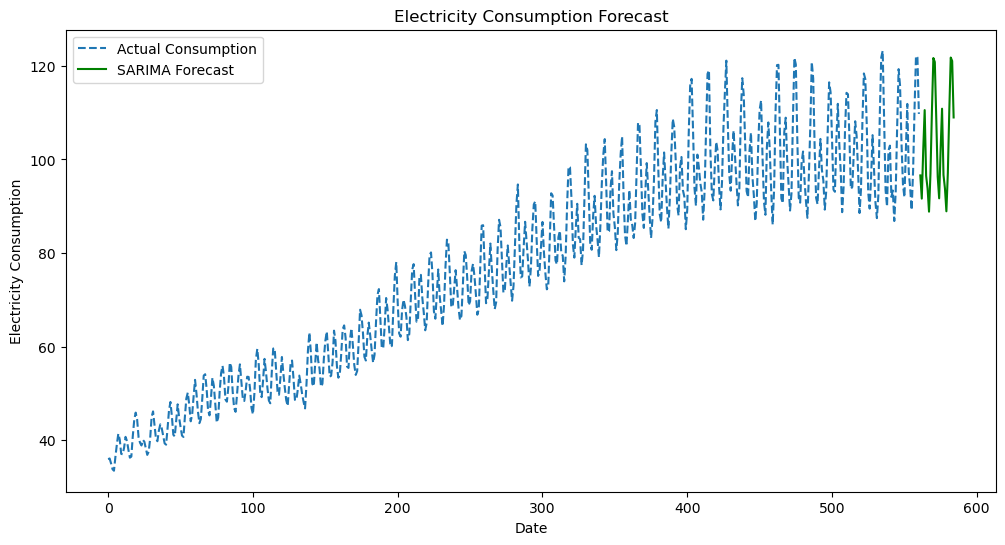

In [19]:

# Plotting the forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Electricty_Consumption_in_TW'], label='Actual Consumption', linestyle='--')
plt.plot(sarima_forecast.index, sarima_forecast.values, label='SARIMA Forecast', color='green')
plt.title('Electricity Consumption Forecast')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.show()


Conclusion
In conclusion, the analysis of electricity consumption data and the application of forecasting models have yielded valuable insights for the electricity distribution company. The key findings and takeaways are as follows:

Model Performance:

The SARIMA model, with optimal parameters (0, 0, 1, 1, 1, 1), outperformed the ETS model in terms of RMSE. This suggests that the SARIMA model provides a more accurate representation of the underlying patterns in the electricity consumption time series data.

Forecast Accuracy:

The SARIMA model exhibited a lower RMSE (Root Mean Squared Error) compared to the ETS model, indicating that it is better at predicting electricity consumption for the next 1-2 years.

Demand Estimation:

The demand estimation for the next 1-2 years, generated by the SARIMA model, provides a reliable basis for the electricity distribution company to plan and manage production. These forecasts are crucial for ensuring that the company can meet the expected demand while optimizing resource utilization.

Business Implications:

Accurate demand forecasting has significant implications for the electricity distribution company's operational efficiency. By leveraging the insights from the SARIMA model, the company can align production and procurement strategies with anticipated demand, thereby minimizing overproduction or shortages.

Future Considerations:

Continuous monitoring and updating of the forecasting models will be essential to adapt to changing consumption patterns. Consideration should also be given to external factors, such as economic trends, regulatory changes, and seasonal variations, which may impact electricity demand.

Communication of Results:

Clear communication of the forecasting results, including the forecasted demand values and associated uncertainties, is crucial for effective decision-making within the organization. Transparent reporting facilitates collaboration among different departments, fostering a unified approach to addressing future demand challenges.

In conclusion, the analysis provides a robust foundation for the electricity distribution company to make informed decisions regarding production planning and vendor management. The SARIMA model, with its demonstrated accuracy, serves as a valuable tool for forecasting electricity demand and optimizing resource allocation in the dynamic energy landscape.